<a href="https://colab.research.google.com/github/Nageswar-Sahoo/Computer-Vision-Project/blob/main/S8/Untitled0_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!git clone https://github.com/Nageswar-Sahoo/Computer-Vision-Project.git

Cloning into 'Computer-Vision-Project'...
remote: Enumerating objects: 737, done.
remote: Counting objects: 100% (737/737), done.
remote: Compressing objects: 100% (616/616), done.
remote: Total 737 (delta 469), reused 285 (delta 106), pack-reused 0
Receiving objects: 100% (737/737), 2.61 MiB | 14.92 MiB/s, done.
Resolving deltas: 100% (469/469), done.


In [11]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

In [9]:
ls 

sample_data/


In [6]:
cd ..

/


In [7]:
cd content

/content


In [8]:
rm -rf Computer-Vision-Project

In [12]:
cd Computer-Vision-Project/template

/content/Computer-Vision-Project/template


In [15]:
!python main.py

170499072it [00:02, 63747045.61it/s]                   
Extracting data/cifar-10-python.tar.gz to data/
length
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): Batc

In [13]:
import data_loader.data_loaders as module_data
from parse_config import ConfigParser
from trainer import Trainer
from utils import prepare_device
import torch
import numpy as np
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import logging
import utils.grad_cam as grad_cam
import matplotlib.pyplot as plt

from utils import GradCAM, GuidedBackpropReLUModel
from utils.image import show_cam_on_image
import cv2
import numpy as np
import torch
import model.model as module_arch

SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [14]:
cat model/model.py

import torch
import torch.nn as nn


import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        

In [15]:
cat config.json

{
    "name": "CIFR10",
    "trainer": {
        "epochs": 40,
        "save_dir": "saved/",
        "save_period": 1,
        "verbosity": 2,
        "monitor": "min val_loss",
        "early_stop": 40,
        "tensorboard": true
    }
}


In [17]:
    logger = logging.getLogger("trian")
    # Read the config.json
    config = ConfigParser.from_args()

    # setup data_loader instances
    data_loader = module_data.CIFRDataLoader(data_dir='data/', batch_size=64, shuffle=True, validation_split=0.1,
                                             num_workers=2, training=True)
    valid_data_loader = data_loader.split_validation()

    print("length")
    print(data_loader.valid_sampler)

    # build model architecture, then print to console
    model = module_arch.ResNet18()
    logger.info(model)

    # prepare for (multi-device) GPU training
    n_gpu = 1
    device, device_ids = prepare_device(n_gpu)
    model = model.to(device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)

    # get function handles of loss and metrics
    criterion = module_loss.crossentropyloss
    metrics = [module_metric.accuracy]

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    trainer = Trainer(model, criterion, metrics, optimizer,
                      config=config,
                      device=device,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler)

    trainer.train()

Files already downloaded and verified
length
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Bat

In [22]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


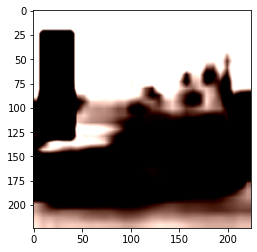

In [ ]:
import cv2
import matplotlib.pyplot as plt
im = np.moveaxis(missclassifiedimage[1], 0, 2)
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


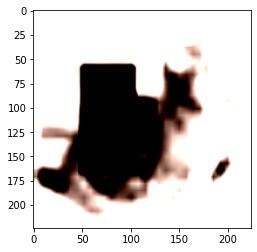

In [ ]:
import cv2
import matplotlib.pyplot as plt
im = np.moveaxis(missclassifiedimagecorrect[4], 0, 2)
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

In [30]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=trainer.model
missclassifiedimage=[]
missclassifiedimage_actual_label=[]
missclassifiedimage_predicted_label=[]
with torch.no_grad():
            for batch_idx, (data, target) in enumerate(trainer.valid_data_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability             
                pred=pred.cpu().numpy()
                target=target.cpu().numpy()
                data=data.cpu().numpy()
                for i in range(len(target)):
                    if pred[i] != target[i]:
                        missclassifiedimage.append(data[i])
                        missclassifiedimage_actual_label.append(target[i])
                        missclassifiedimage_predicted_label.append(pred[i][0])

In [31]:
missclassifiedimage_cam=[]
model = trainer.model
target_layers = [model.layer2[-1]]
target_category = None

for i in range(20):
  img = np.moveaxis(missclassifiedimage[i], 0, 2)
  img = np.float32(cv2.resize(img, (32, 32))) / 255
  img_r = np.moveaxis(img, -1, 0)
  preprocessed_img = torch.from_numpy(img_r)
  preprocessed_img.unsqueeze_(0)
  cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
  grayscale_cam = cam(input_tensor=preprocessed_img, target_category=target_category)
  grayscale_cam = grayscale_cam[0, :]
  cam_image_op = show_cam_on_image(img, grayscale_cam, use_rgb=False)
  missclassifiedimage_cam.append(cam_image_op)

0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
1
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
3
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
4
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
6
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
7
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
8
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for int

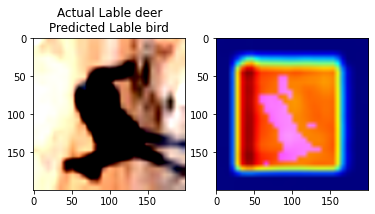

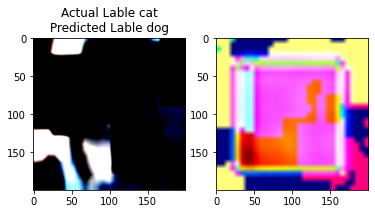

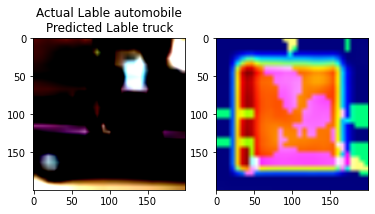

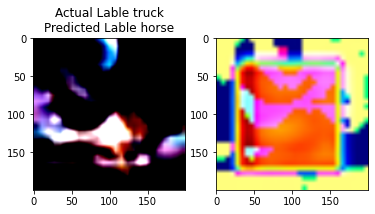

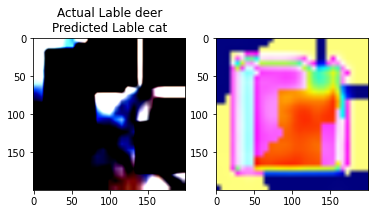

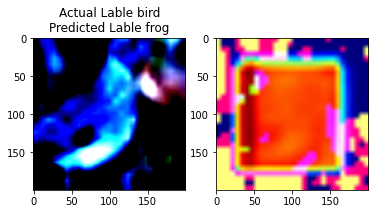

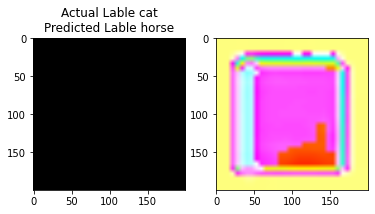

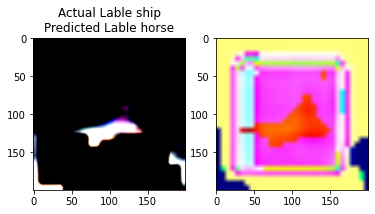

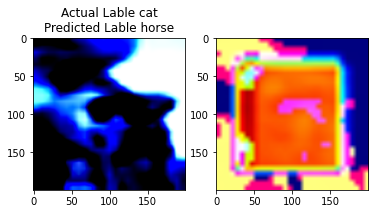

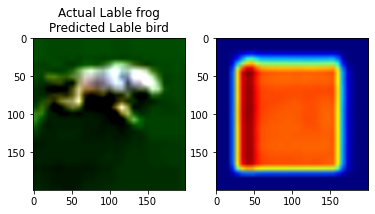

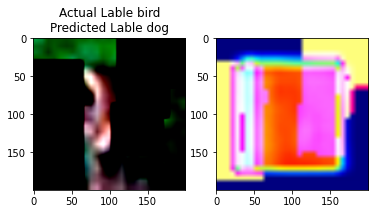

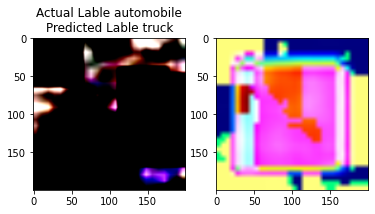

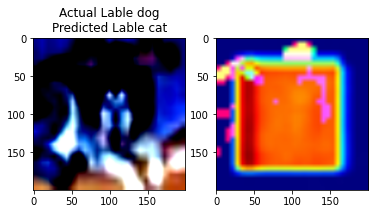

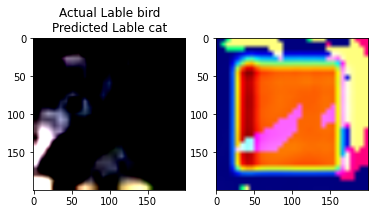

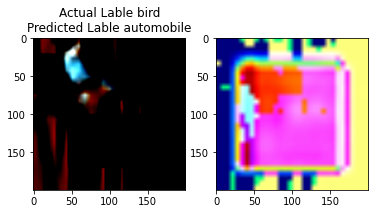

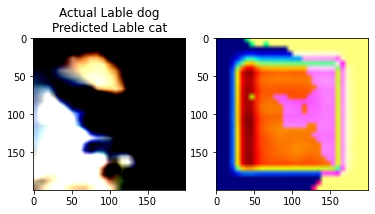

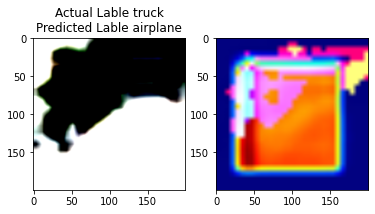

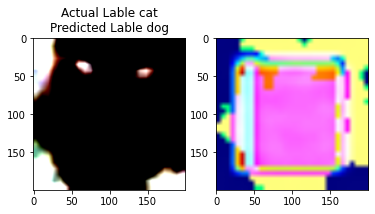

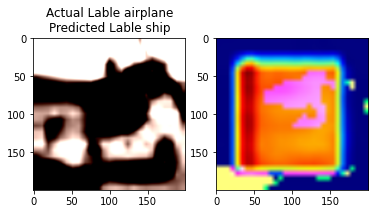

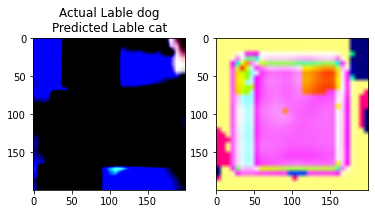

In [32]:
import matplotlib.pyplot as plt
for idx in np.arange(20):
    print(idx) 
    fig, ax1 = plt.subplots(1,2)
    im = missclassifiedimage[idx]
    im=np.moveaxis(im, 0, 2)
    im_resized = cv2.resize(im, (200, 200), interpolation=cv2.INTER_LINEAR)
    cam_im = missclassifiedimage_cam[idx]
    cam_im_resized = cv2.resize(cam_im, (200, 200), interpolation=cv2.INTER_LINEAR)
    ax1[0].imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
    ax1[0].title.set_text(str('Actual Lable ') + classes[missclassifiedimage_actual_label[idx]]+ str('\nPredicted Lable ') + classes[missclassifiedimage_predicted_label[idx]])
    ax1[1].imshow(cv2.cvtColor(cam_im_resized, cv2.COLOR_BGR2RGB))

